# Content Report Generator for ArcGIS Online

In [1]:
VERSION = "0.8"

## Readme

### **What is this notebook used for?**

This notebook will generate an Excel report of all your GIS content. The following fields are provided:

    • Item Name          • Groups         • Project ID
    • Author             • Item ID 
    • Sharing Levels     • Description
    • Date last updated  • URL
    • Type               • Folder
    • Tags               • Categories
    • Content Status     • Related Items
    • Delete Protection  • Transfer Status

Content Status refers to if the item is deprecated or authoritative in ArcGIS Online.

Related Items are all the other ArcGIS Online items which are used as resources for the item. For example, a Dashboard might have a web map embeded in it as well as another dashboard. Both of those Item IDs would appear in this column.

Project ID is a randomly generated ID that displays what projects an item belongs to. Items which are the project themselves (like a dashboard) will be assigned an ID, and its components will also be assigned this ID. Root Items, a.k.a projects, will only have one Item ID. However, a Web Map used in a dashboard as well as a Story Map project would have two Project IDs associated with it. This is useful for understanding the dependencies of items to one another in your content. 

Transfer Status reports if this item has been transferred to the Consumer Goods and Services ArcGIS Online Org. 

### **How do I use this notebook?**

The only configuration required for this notebook is under the heading **Constants (CONFIGURE HERE!)**. 

For **MY_ORG**, enter the URL to your organization. By default, this is specified as "home".

For **ORG_USER**, enter the username associated with that organization. **These are the only edits you need to make to the entire notebook**.

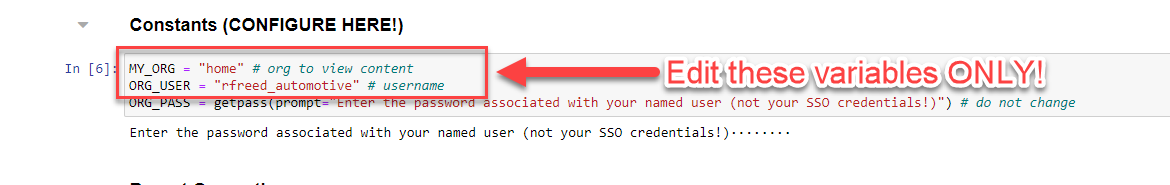

After running the cell, you will be prompted to enter the organization user password in the box below. Type your password into the box.

Next, simply just run the rest of the cells and your report will be generated.

To download your report, click the **Files** button on the very top ribbon of this page, not to be confused with the **File** dropdown inside the notebook editor.

Your notebook with your username and time of creation will appear in a panel on the lefthand side. Click it to download it in your web browser:

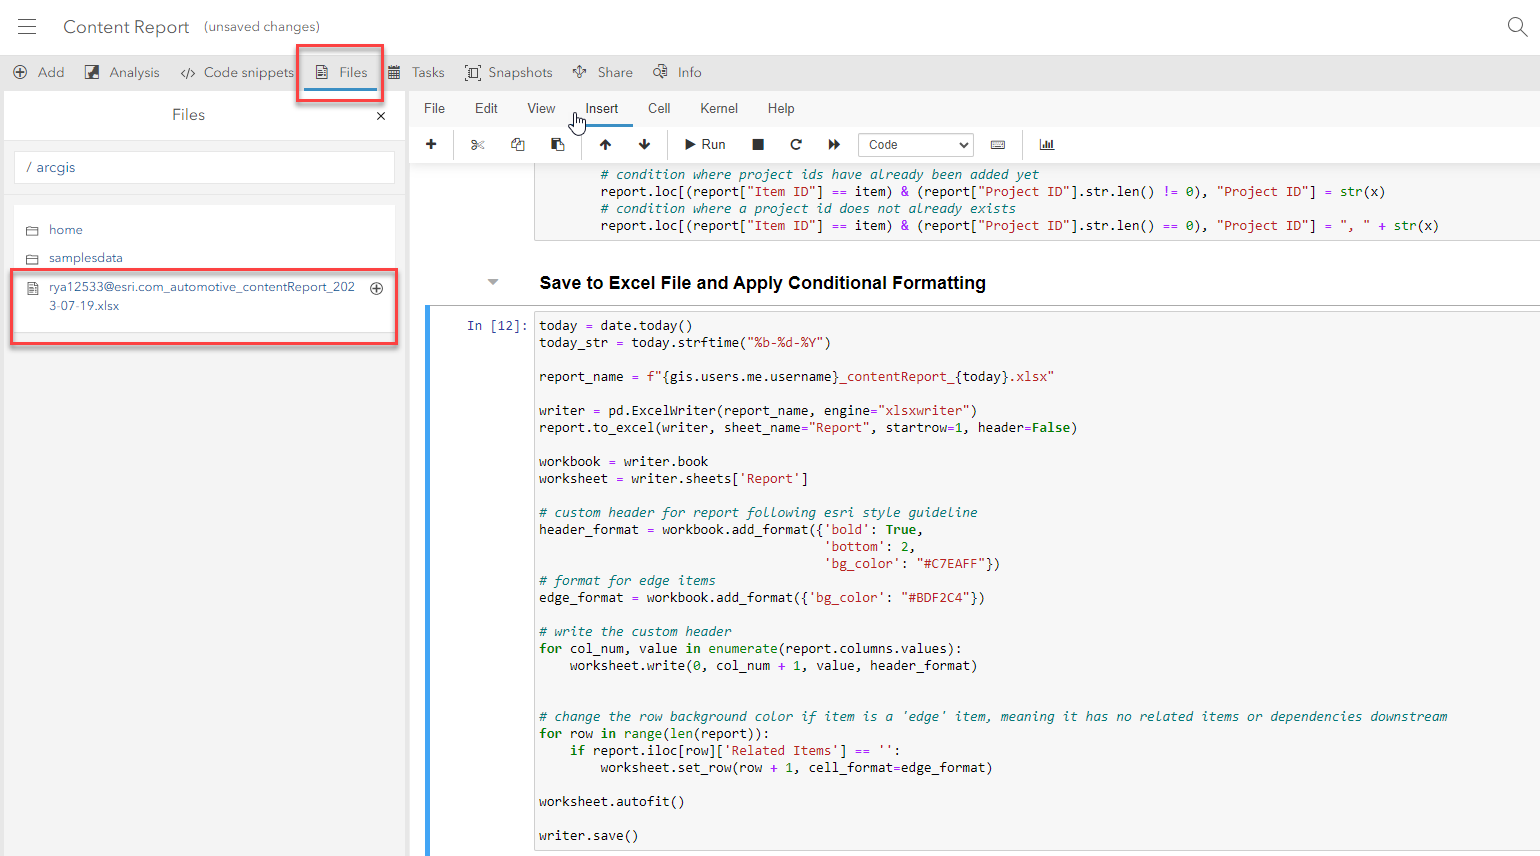

### **Some of the cells have outputs. What are they?**

There are two **optional** outputs to better understand the data.

The first output is a preview of your report as a Pandas dataframe, which will look close to the following:

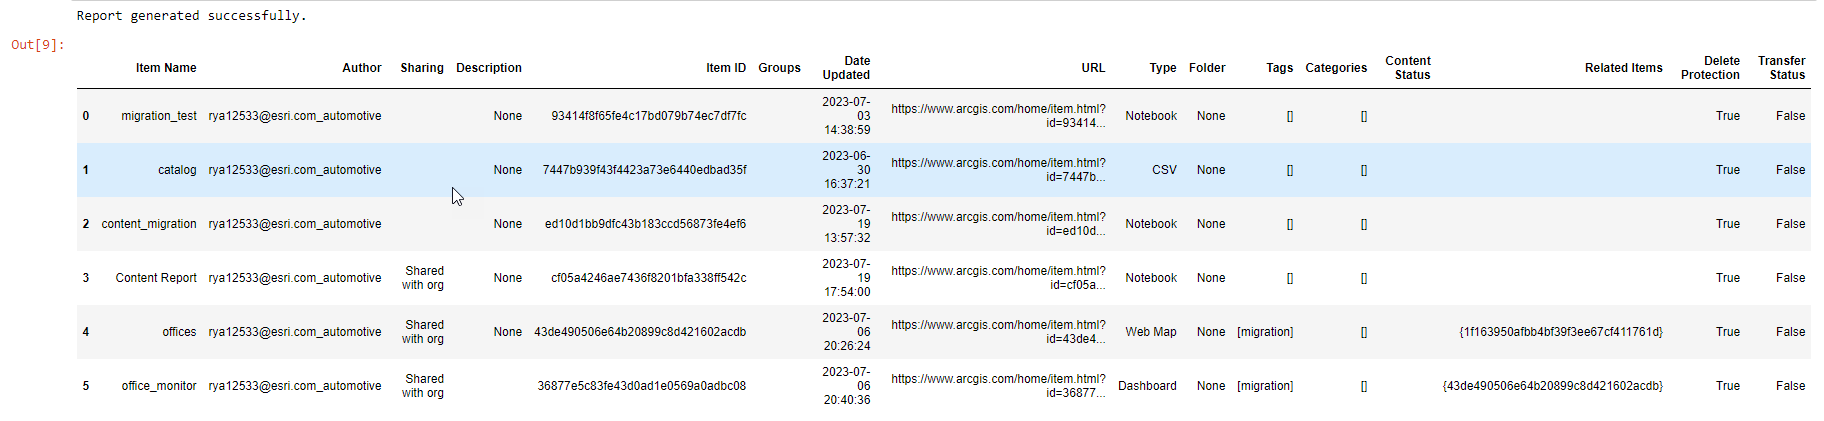

The second output is a directional graph that describes the relationship between your content. Items with no parents (with no arrows pointing **to** it) are your projects which are not a dependency for any other items. For example, a Story Map typically is found on its own and is not generally embeded inside other content. However, the Story Map might use a web map and dashboard, and that node will point to both of those items. Each node label is the Item ID for a given item. 

In this example, the bottom right node is a dashboard which uses a web map. That web map uses a Living Atlas layer, represented as the node in the top left:

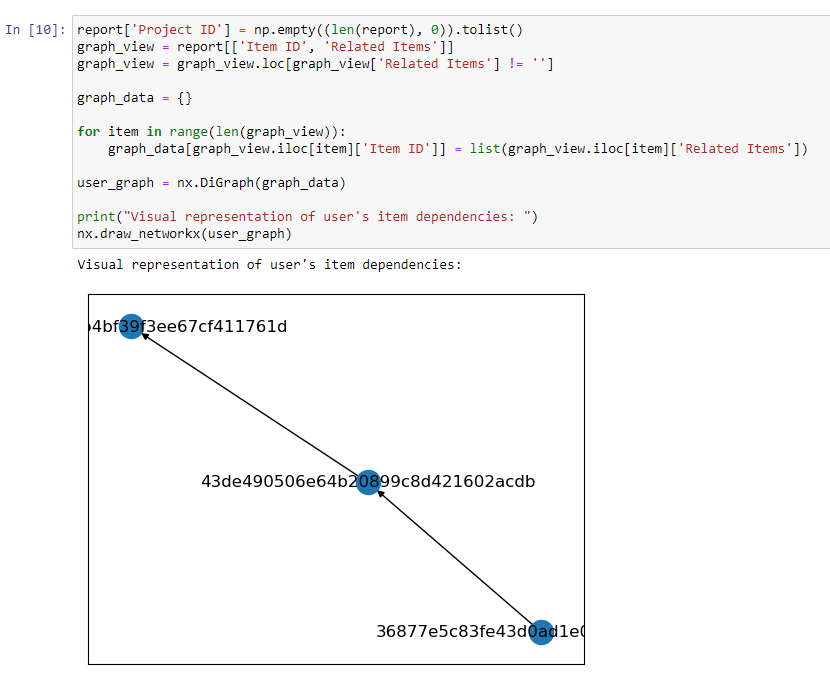

### Some of this functionality is really useful. Can I run those operations standalone in other scripts or notebooks?

Yes! Most of this functionality, outside of the dataframe and Excel generation itself, is completely modular. Just make sure to import the appropriate dependencies. Feel free to copy these functions and give credit to the appropriate author. I also have made the relation graph process into a standalone script. Feel free to reach me at **rfreed@esri.com** or on Microsoft Teams if you are interested in using it!

## Generate the Report

### Constants (CONFIGURE HERE)!

In [ ]:
MY_ORG = "home" # org to view content
ORG_USER = "rfreed_automotive" # username
CSV_ITEM_ID = ""

### Imports

In [3]:
from arcgis.gis import GIS
from arcgis.gis import Item
from arcgis.gis import ContentManager
from arcgis import __version__
from arcgis.mapping.ogc import CSVLayer
from datetime import datetime, date
import ipywidgets as widgets
import sys
import numpy as np
from itertools import islice

import pandas as pd
import tempfile

import os
import uuid
import json
import shutil
import tempfile

from getpass import getpass

In [4]:
!{sys.executable} -m pip install xlsxwriter
!{sys.executable} -m pip install networkx
import xlsxwriter
import networkx as nx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 13.6 MB/s eta 0:00:00


### Helper Functions

In [5]:
def flatten_data(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

In [6]:
# source: https://stackoverflow.com/questions/56802797/digraph-parallel-ordering

def topological_sort_grouped(G):
    """
    Performs a topological sort where nodes entering the queue at the same time are stored in the same element. 
    
    Arguments:
        - G: <Networkx Directed Graph>
    Returns:
        - <iterator>
        
    Source: https://stackoverflow.com/questions/56802797/digraph-parallel-ordering
    """
    indegree_map = {v: d for v, d in G.in_degree() if d > 0}
    zero_indegree = [v for v, d in G.in_degree() if d == 0]
    while zero_indegree:
        yield zero_indegree
        new_zero_indegree = []
        for v in zero_indegree:
            for _, child in G.edges(v):
                indegree_map[child] -= 1
                if not indegree_map[child]:
                    new_zero_indegree.append(child)
        zero_indegree = new_zero_indegree

In [ ]:
def chunks(lst, n):
    """
    Divides a lst into chunks of size n.
    """
    
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

### Report Generation

In [8]:
# Establish GIS connection
print("Connecting ...")
gis = GIS("home", expiration=9999)
print("Connection successful.")

Connecting ...
Connection successful.


/opt/conda/lib/python3.9/site-packages/arcgis/gis/__init__.py:676: UserWarning: You are logged on as rya12533@esri.com_automotive with an administrator role, proceed with caution.
  warnings.warn(


In [ ]:
# get all of my items

RELATIONSHIP_TYPES = frozenset(['Map2Service', 'WMA2Code',
                                'Map2FeatureCollection', 'MobileApp2Code', 'Service2Data',
                                'Service2Service'])

me = gis.users.search(ORG_USER)[0]
my_items = me.items(max_items = 9999)
    
folders = me.folders

for folder in folders:
    folder_items = me.items(folder=folder['title'], max_items=9999)
    for item in folder_items:
        my_items.append(item)

In [9]:
csvItem = gis.content.get(CSV_ITEM_ID)
catalog = CSVLayer(csvItem).df

In [29]:
dict_list = []

total_items = len(my_items)

for chunk in chunks(my_items, 100):
    for item in my_items:
        
        # format item sharing data
        item_share = ""
        if item.shared_with['everyone']:
            item_share += "Shared with everyone"
        if item.shared_with['org']:
            item_share += "Shared with org"

        # delete protection string
        if item.protect:
            deletion_status = "True"
        else:
            deletion_status = "False"
            
        # check if its xferred
        if item.id in catalog['source_id'].unique():
            xfer = "True"
        else:
            xfer = "False"
            
        # last edit string
        last_edit = datetime.fromtimestamp(item.modified/1000).__str__()
        
        # get related items (heavy resource cost)
        related_ids = []
        item_json = item.get_data(try_json=True)
        flat_keys = flatten_data(item_json)

        for k, v in flat_keys.items():
            if "itemId" in k:
                related_ids.append(v)
                
        for fldr in folders:
            if fldr['id']==item.ownerFolder:
                fldr_name =fldr['title']
            else:
                fldr_name = 'root'
                    
        related_ids = set(related_ids)
        if len(related_ids) == 0:
            related_ids = ""

        # loop and generate these dictionaries, store in a list
        d = {"Item Name": item.title, "Author": item.owner, "Sharing": item_share, "Description": item.description, "Item ID": item.id, "Groups": item.shared_with['groups'],
                            "Date Updated": last_edit, "URL": item.homepage, "Type": item.type, "Folder": fldr_name, "Tags": item.tags, "Categories": item.categories, 
                            "Content Status": item.content_status, "Related Items": related_ids, "Delete Protection": deletion_status, "Transfer Status": xfer}

        dict_list.append(d)
        del d

print("Report generated successfully.")

report = pd.DataFrame(dict_list)
report

Report generated successfully.


,Item Name,Author,Sharing,Description,Item ID,Groups,Date Updated,URL,Type,Folder,Tags,Categories,Content Status,Related Items,Delete Protection,Transfer Status
0,content_migration,rya12533@esri.com_automotive,,None,ed10d1bb9dfc43b183ccd56873fe4ef6,[],2023-07-19 13:57:32,https://www.arcgis.com/home/item.html?id=ed10d...,Notebook,None,[],[],,,True,False
1,migration_test,rya12533@esri.com_automotive,,None,93414f8f65fe4c17bd079b74ec7df7fc,[],2023-07-03 14:38:59,https://www.arcgis.com/home/item.html?id=93414...,Notebook,None,[],[],,,True,False
2,catalog,rya12533@esri.com_automotive,,None,7447b939f43f4423a73e6440edbad35f,[],2023-06-30 16:37:21,https://www.arcgis.com/home/item.html?id=7447b...,CSV,None,[],[],,,True,False
3,offices,rya12533@esri.com_automotive,Shared with org,None,43de490506e64b20899c8d421602acdb,[],2023-07-06 20:26:24,https://www.arcgis.com/home/item.html?id=43de4...,Web Map,None,[migration],[],,{1f163950afbb4bf39f3ee67cf411761d},True,False
4,office_monitor,rya12533@esri.com_automotive,Shared with org,,36877e5c83fe43d0ad1e0569a0adbc08,[],2023-07-06 20:40:36,https://www.arcgis.com/home/item.html?id=36877...,Dashboard,None,[migration],[],,{43de490506e64b20899c8d421602acdb},True,False
5,Content Report,rya12533@esri.com_automotive,Shared with org,None,cf05a4246ae7436f8201bfa338ff542c,[],2023-08-15 14:49:57,https://www.arcgis.com/home/item.html?id=cf05a...,Notebook,None,[],[],,,True,False


### Build a Directed Graph of Item Relations

In [30]:
report['Project ID'] = np.empty((len(report), 0)).tolist()
graph_view = report[['Item ID', 'Related Items']]
graph_view = graph_view.loc[graph_view['Related Items'] != '']

graph_data = {}

for item in range(len(graph_view)):
    graph_data[graph_view.iloc[item]['Item ID']] = list(graph_view.iloc[item]['Related Items'])
    
user_graph = nx.DiGraph(graph_data)

#print("Visual representation of user's item dependencies: ")
#nx.draw_networkx(user_graph)

In [33]:
roots = list(topological_sort_grouped(user_graph))[0]

for root in roots:
    x = str(uuid.uuid4())[:8]
    # filter for root project
    report.loc[report["Item ID"] == root, "Project ID"] = x
    relates = report.loc[report['Item ID'] == root]["Related Items"].values[0]
    for item in relates:
        # condition where project ids have already been added 
        report.loc[(report["Item ID"] == item) & (report["Project ID"].str.len() != 0), "Project ID"] = x + ", "
        # condition where a project id does not already exists
        report.loc[(report["Item ID"] == item) & (report["Project ID"].str.len() == 0), "Project ID"] = x

### Save to Excel File and Apply Conditional Formatting

In [32]:
today = date.today()
today_str = today.strftime("%b-%d-%Y")

report_name = f"{ORG_USER}_contentReport_{today}.xlsx"

writer = pd.ExcelWriter(report_name, engine="xlsxwriter")
report.to_excel(writer, sheet_name="Report", startrow=1, header=False)

workbook = writer.book
worksheet = writer.sheets['Report']

# custom header for report following esri style guideline
header_format = workbook.add_format({'bold': True,
                                     'bottom': 2,
                                     'bg_color': "#C7EAFF"})
# format for edge items
edge_format = workbook.add_format({'bg_color': "#BDF2C4"})

# write the custom header
for col_num, value in enumerate(report.columns.values):
    worksheet.write(0, col_num + 1, value, header_format)


# change the row background color if item is a 'edge' item, meaning it has no related items or dependencies downstream
for row in range(len(report)):
    if report.iloc[row]['Related Items'] == '':
        worksheet.set_row(row + 1, cell_format=edge_format)
        
worksheet.autofit()
    
writer.save()